# **Add the dataset to your working folder**

Press on **Add data** (Upper right corner) and search for "Satellite image classification". Click on the **add** button and you should see under the **Input** Flag on the right (just over **Output**) the dataset folder. If you pass your mouse on the right of the name you should see an icon to copy its path.

Image below shows the final output:

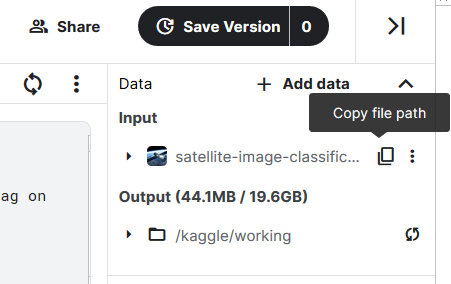

With the filepath you can access the dataset

            ../input/satellite-image-classification

# **Dataset exploration**

First thing to do is to read the dataset description. From it's kaggle page:

_Satellite image Classification Dataset-RSI-CB256 , This dataset has 4 different classes mixed from Sensors and google map snapshot_

The task is then to **define a classifier** that is able to recognize those 4 classes. 

You can navigate the dataset using the toggle menu

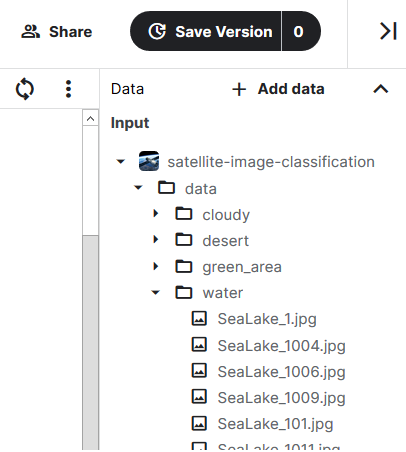

Classes are divided by folder. There are ready-to-use fastai dataloaders to access this kind of data. Let's see some images from the 4 classes and examine their properties

In [1]:
from fastai.vision.data    import *   # ImageDataLoaders 
from fastai.vision.augment import *   # Resize

help(ImageDataLoaders.from_folder)

ddir = '../input/satellite-image-classification/data'
                                                                  # Dataloader definition:
data = ImageDataLoaders.from_folder(ddir,                         # Directory
                                    valid_pct=0.1,                # % of the validation split
                                    item_tfms=Resize((64,64)),    # Transforms per item
                                    bs=8,                         # Batch size
                                    num_workers=2)                # Number of processes that load the dataset    

data.show_batch()

## Notes:

We can already say something about the dataset:

- Resolution is really low and images do not show many features
- Color is the main difference. If we manipulate the images (for augmentation or normalization) we have to be wary not to destroy color
- The couples "Cloudy/Desert" and "Green area/Water" are somewhat similar
- There are no evident problems


Since the dataset seems to be already OK, we can proceed to the training

## **Training**

Fastai allows to defined a model with very few lines of code

**Note on GPU:**

Need to set **accelerator** on **GPU** in order to make _learn.cuda()_ work

1. modelli da usare: alexnet, resnet34, densenet201
2. cicli: 1,2,3

In [ ]:
from fastai.basics      import *   
from fastai.vision.all  import *   


# INSERT HERE TRAINING ROUTINE
learn = cnn_learner(data, alexnet, metrics=error_rate)
learn.fine_tune(3)

learn.show_results(1)                         # Showing some results on the validation set (idx=1)

We can see how the model generalizes well and, as expected, in some cases there is confusion between desert/cloudy and water/green_area. But the task is inherently difficult, as in those cases it is not straightforward even for human eyes

## **Testing**

Precision is here computed on the validation dataset

In [ ]:
counts   = 0
corrects = 0

learn.eval()  # Learner in evaluation mode. Cuts out gradient computation (not used for inference)

for x in enumerate(data.valid):  # Validation dataset
    
    gt    = x[1][1].cuda()  # Labels (on cuda, as the trainer is already on cuda)
    batch = x[1][0].cuda()  # Images
    
    fw    = learn.forward(batch)   # Forwarding batch
    
    preds = torch.argmax(fw,dim=1) # Taking max confidence as predicted class
    check = gt==preds              # Comparing predictions and ground truths
    
    counts   += gt.shape[0]              # Number of images
    corrects += torch.sum(check).item()  # Number of correct predictions
    
print('Final precision on valid set:')
print('{}/{}, accuracy {:.4f}%'.format(corrects,counts,corrects/counts))

